In [2]:
using PyPlot
using Distributions
using LinearAlgebra
using Flux;

In [243]:
#Hyperparameters
n = 1000
N = 4000
σₐ = 0.001
k_range = 6
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] #November 3
k_list_lite = [i for i in 1:k_range];

In [244]:
#Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::Array{Float64})
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

mₖ(k) = k*4 + 1;

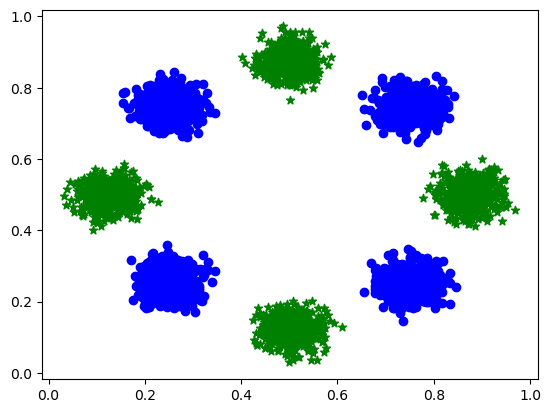

(2, 4000)(4000,)

In [245]:
#Scale up - Fixed Separable Data - Multi-XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [0.25, 0.25]
    μ₂ = [0.5, 0.125]
    μ₃ = [0.25, 0.75]
    μ₄ = [0.125, 0.50]
    μ₅ = [0.75, 0.75]
    μ₆ = [0.50, 0.875]
    μ₇ = [0.75, 0.25]
    μ₈ = [0.875, 0.50]
    μ = [μ₁, μ₂, μ₃, μ₄, μ₅, μ₆, μ₇, μ₈]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/8), 8, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y = classes .- 1

plot_data(data_raw,classes)
data = transpose(data_raw)
x = data
x_raw = data_raw
print(size(data))
print(size(y))

In [8]:
#Neural Nets with Different k
function model(k::Int) 
    return Chain(
  Dense(2, k, relu),
  Dense(k, 1, σ))
end

model2 = Chain(
  Dense(2, 2, relu),
  Dense(2, 1, σ))

model3 = Chain(
  Dense(2, 3, relu),
  Dense(3, 1, σ))

model4 = Chain(
  Dense(2, 4, relu),
  Dense(4, 1, σ))

Chain(Dense(2, 3, relu), Dense(3, 1, σ))

In [159]:
## utility functions

num_params(model) = sum(length, Flux.params(model)) 

round4(x) = round(x, digits=4)

loss(y_hat, y) = Flux.binarycrossentropy(y_hat, y)

function accuracy(x,y)
    labels = [x[i] > 0.5 ? 2.0 : 1.0 for i in 1:length(x)]
    scores = [labels[i] == y[i] for i in 1:length(x)]
    return sum(scores)/length(x)
end

function eval_loss_accuracy(x, y, net)
    l = 0.0
    acc = 0
    ntot = 0
    for i in 1:length(y)
        ŷ = (net(x[:,i]))[1]
        l += loss(ŷ, y[i])   
        acc += (round(ŷ) == y[i])

        ntot += 1[end]
    end
    return (loss = l/ntot |> round4, acc = acc/ntot*100 |> round4)
end

test = model(2)
z = eval_loss_accuracy(x, y, test)
print(z)


function test_net(x,y,m)    
    ps = Flux.params(m)
    opt = Descent(0.1)
    data = [(x, y)]
    for i=1:10
        (loss, acc) = eval_loss_accuracy(x,y,m)
        Flux.train!(loss, ps, data, opt)
        if i%10 == 0
            println(loss)
            println(acc)
        end
    end
end

function test_net2(x,y,net)
    ps = Flux.params(net)
    opt = Descent(0.1)
    for i in 1:length(y)
        gs = Flux.gradient(ps) do
            ŷ = (net(x[:,i]))
            loss(ŷ, y[i])
        end
        #Flux.Optimise.update!(opt, ps, gs)
    end
end

2test_net2(x,y,test)

#test_net(x,y,model1)
#test_net(x,y,model2)
#test_net(x,y,model3)
#test_net(x,y,model4)

(loss = 0.6931, acc = 50.0)

┌ Warning: `binarycrossentropy(ŷ, y)` is deprecated, use `Losses.binarycrossentropy(ŷ, y, agg = identity)` instead.
│   caller = loss at In[159]:7 [inlined]
└ @ Core ./In[159]:7


ErrorException: Output should be scalar; gradients are not defined for output [0.6931469440460205]

In [295]:
z = test(x)
z = [round(z[i]) for i=1:length(z)]
print(size(z))
#println(z[500:4000])
#println(y[500:1000])
new_test = [[z[i] == y[i] for i=1:length(y)]]
print(size(new_test)[1])
print(sum(new_test[1]))

(4000,)12000

In [316]:
function getdata(x,y)
    # Reshape Data in order to flatten each image into a linear array
    xtrain = Flux.flatten(x)

    # One-hot-encode the labels
    ytrain = Flux.onehotbatch(y, 0:1)
    print(ytrain)

    # Batching
    train_data = Flux.Data.DataLoader(xtrain, ytrain, batchsize=1000, shuffle=true)

    return train_data
end

w = getdata(x,y)
print(w)

function eval_loss_accuracy(x, y, net)
    l = 0.0
    accs = 0
    ntot = 0
    loss = 0
    z = net(x)
    z = [round(z[i]) for i=1:length(z)]
    targets = [[z[i] == y[i] for i=1:length(y)]]
    acc = sum(targets[1])
    #println(acc)
    #for i in 1:length(y)
        #ŷ = (net(x[:,i]))[1]
        #l += loss(ŷ, y[i])   
        #acc = (round(ŷ) == y[i])
        #accs += acc
    #end
    return (loss = l/ntot |> round4, acc = acc/length(y)*100)
end

losses = []
accs = []
function train(x,y,k)
    # Load Data
    train_data = getdata(x,y)

    # Construct model
    m = model(k)
    loss(x,y) = Flux.Losses.binarycrossentropy(m(x), y)
    
    ## Training
    opt = ADAM(0.0001)

    for i=1:3000
        Flux.train!(loss, Flux.params(m), train_data, opt)
        loss1, acc = eval_loss_accuracy(x,y,m)
        push!(accs, acc)
        if i%200 == 0
            #loss1, acc = eval_loss_accuracy(x,y,m)
            #push!(losses,loss1)
            println(acc)
            #println(Flux.params(m))
        end
        #println(Flux.params(m))
    end
end

#train(x, y, 10)

Bool[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

 0.26562972948642677 0.2606165589954888 0.27491897469858434 0.22233959340010317 0.23096936782677502 0.23796119903615084 0.24464329462127946 0.27189215325768246 0.2686337072120702 0.26372834647419713 0.2711683832245936 0.28612921646797984 0.26724382512954115 0.2772849161009484 0.25217974093679346 0.24897676084770182 0.2000099995391003 0.21405992754017825 0.21671514320036608 0.21487705206812857 0.1899383713594031 0.3223860978818569 0.26456545381375285 0.27734601539459475 0.2673530882945771 0.2972246228294761 0.2430520817217877 0.21761983859053696 0.3062021730128438 0.2729422820203412 0.2613241880540517 0.2628125089422605 0.25594169248315646 0.19791234019688814 0.24684400196714568 0.2517476594697544 0.24706712225048927 0.2619119799760208 0.23062681373236246 0.23485141067848686 0.2469475038223459 0.2393135781250062 0.22441465589856688 0.17209249775619662 0.22857812196795563 0.26981257575372986 0.28405296622260495 0.2481429819763243 0.24397934713920202 0.2651652519718195 0.21909290975168821

 0.4681765590253973 0.5513985965544439 0.5135238209716777 0.5045419319069323 0.4817380898450141 0.5086385737655852 0.4796229870102047 0.44852127478120746 0.48816768990914333 0.46570525522819445 0.48620457812584866 0.4916657637213174 0.5090742467628544 0.4814153214167894 0.4485588597604896 0.4900430352943396 0.4792539418664583 0.4855294750155004 0.5328329925311356 0.5455575686258821 0.5030092109255664 0.46203611014874674 0.54797450790246 0.5236556396580784 0.4904980420535407 0.5255911590973334 0.5591514042213672 0.5353135040677585 0.45617609767145734 0.5467344846129585 0.48672130905424843 0.47934822452663 0.4688907993508285 0.4891053823111063 0.4601070147003994 0.5247060670704693 0.5620424988220614 0.5618731702779911 0.521612551189803 0.5072531203290953 0.4956798376264488 0.5099093034768676 0.49209420930117004 0.49551607500841693 0.5674515988332034 0.49955724077738295 0.5059187667463 0.5142171055498908 0.4383450484871421 0.4872174075624137 0.49452837976311204 0.4935188169565033 0.514289

 0.27585475660229364 0.28137229975737765 0.26744433910996324 0.21780425086336588 0.29919341839894803 0.25886899112729833 0.21070897581442627 0.15408550779244837 0.260135987719913 0.31118067827086776 0.3134322958297565 0.24643984575257005 0.29434567352130686 0.2737379826806803 0.2723767279836387 0.2938156497886025 0.26682507998986366 0.2493916088473762 0.2471779997552807 0.2308924956026239 0.24271071915037143 0.21124309725605891 0.27756902008190304 0.21132564031800322 0.1935959020454855 0.2215351449252021 0.23082651533058043 0.2061850038574295 0.23269298884663814 0.23192980141509523 0.22914288803176178 0.22100839512325443 0.25530871975360014 0.260067673454178 0.27714340878734783 0.24825409755542852 0.2313519986335307 0.20101834769925198 0.24003481464269094 0.22860276416281616 0.2564430789997934 0.2650849197047684 0.24267465558119544 0.26467820591481456 0.22298125206119404 0.24367982336322028 0.24942713298904495 0.2969108821523563 0.21939192976090616 0.15838262606320913 0.219971460126333

 0.11879995248427773 0.11810169731917643 0.17878331383976076 0.1524134939755628 0.12398471040293864 0.1268452024786029 0.12226306674846688 0.12052290694554342 0.18256011010603476 0.0962158260992122 0.08779908533206238 0.10868980713399475 0.0953172405207712 0.10281233943018558 0.08968615288310171 0.14803342816690007 0.062069663788706875 0.11331647277391924 0.05350191099615276 0.08567387673541345 0.12013566631848209 0.13400865405487783 0.1876412078865176 0.10624668133747994 0.110172196868189 0.15533867579605884 0.13701298650190605 0.11771251371724714 0.11894816499749314 0.1549525325592616 0.13762288773432793 0.19302211342413123 0.07405875116338134 0.1325474238628876 0.12397042453894035 0.1415188458116139 0.11490261049363522 0.08540863865952475 0.1233694395198804 0.06682352031677319 0.14809068491894217 0.1280000725786147 0.12022505547368477 0.13983184204663884 0.11177431752060575 0.12673083321163525 0.14821714466107197 0.1227535375803218 0.1496061353864901 0.15944406784250198 0.0892620348

 0.7314746504758719 0.7615233021995452 0.7790305753148347 0.7894613121707289 0.7301923117111163 0.7934288053450117 0.7850636197687354 0.6785414445885969 0.7139605206802225 0.805965671849099 0.7275298326276367 0.7303578563762795 0.7750927846225386 0.7335415391253444 0.7730943948628964 0.7018206831071362 0.8043986428071436 0.7534249038382003 0.74715898082705 0.7531211012243542 0.8123708083365785 0.6909004877908844 0.7712003351407772 0.7633012690658784 0.7394461378444465 0.7274675146692791 0.7626776920726956 0.7210536268959024 0.7357265150369874 0.8073777164669408 0.8116978743808277 0.7464752597066561 0.723224914189561 0.7238223052537087 0.8002217296165733 0.7059934172589392 0.7631201472076006 0.7256593556341686 0.7353600369932127 0.7509606372510693 0.7408781639432929 0.7608735222518388 0.7213653636456441 0.8209435731213863 0.7898021128242664 0.7679384380620622 0.7262729774697895 0.7033915950843874 0.7672480977335384 0.7780836458946133 0.8100400607393624 0.7271479804427236 0.7312964828716

 0.5230205889400048 0.4996291320250066 0.5059529065594539 0.49169992592848916 0.48477812870745657 0.4865705790983 0.48080551808196903 0.5085360302373115 0.5580599125710681 0.5100968794684602 0.45540840981464764 0.5149430388399661 0.4464209705979629 0.4929442325259536 0.47536022230652925 0.493928450220227 0.4731515037772661 0.49605900614484666 0.47743987248649045 0.4563306589898419 0.4596914506394999 0.4644936834636464 0.49650472246439314 0.46939607695760915 0.4424869330182185 0.5414103619309891 0.5141036033584008 0.4769763168109204 0.5363615275117081 0.5051933273896099 0.4018927047854388 0.5019893080266339 0.5337204270705734 0.5033533629210251 0.5529999556904112 0.49096885066252544 0.4620052211037563 0.504954168215919 0.47952142167884343 0.451845373860569 0.5701900946135116 0.48224726127426987 0.49925450816422784 0.5077201759540837 0.4670165878214962 0.5206619565604921 0.47177794713805665 0.48472976117069727 0.5369604789751121 0.5414425945499434 0.45708146987888604 0.5251880792739926 0

 0.7456075011892154 0.7312846961115448 0.7169622834370792 0.769130932061061 0.759037075409209 0.7940305938097852 0.7371286561281111 0.7676883991106784 0.7842861250797265 0.7360086799584233 0.7398278261617119 0.8048705687232989 0.7307521662165979 0.816116505612409 0.7841422827961184 0.7804978668694015 0.7308186892229716 0.7129174456501605 0.7342831304041817 0.7880742415606312 0.7413347072919318 0.7547659623637535 0.777937864193916 0.7837294505948079 0.7330183282636946 0.76699508268968 0.7494016366808834 0.715711866081809 0.7040330356570046 0.7829856449845751 0.7392586136376592 0.7492548064951242 0.7496706280434495 0.7250861348485148 0.7171931341309946 0.7409522525386053 0.7706503155439848 0.7586032397011985 0.7840104021083621 0.7353198640389104 0.7811118893648976 0.8338269618828485 0.8342541204755133 0.7205494367914718 0.7229347865626415 0.7237586603521945 0.8077318796295039 0.7821150665001659 0.7572362158245504 0.7876176934959047 0.7883233707944065 0.8017464695354818 0.7293835180273861

 0.31319792599072815 0.22384518308249365 0.2176827096390486 0.2810551667860144 0.23914611755917287 0.23268452975961632 0.2559790513899862 0.207775047255822 0.2589399213540335 0.24776575674175388 0.2527333614858107 0.2541729645990359 0.20720435316543062 0.24716952119637803 0.27956489420000824 0.2399874507972498 0.27580740355047656 0.27375269748378933 0.2853306870414731 0.275122914701825 0.2548513643319037 0.2742879099646307 0.2610837769979761 0.2058508216409692 0.29175034305332254 0.2599890781069484 0.27580426104497513 0.2446027577654692 0.2960126558854969 0.2364245314491587 0.24646055742720566 0.26364672281397666 0.26863064268809916 0.27743063106593685 0.253814181251227 0.3214933652935164 0.2811470094416284 0.2678957637871011 0.2736870183075275 0.2367941194994614 0.30007608826834714 0.2673730392270831 0.23684447807673117 0.23460293614362945 0.24662542904468587 0.24576762653868278 0.24365453670902598 0.2679878135959127 0.26942136955300483 0.2568798906033698 0.2576718347789637 0.25818170

 0.10964280185150013 0.09294483985041697 0.12862092972107117 0.11138587542359005 0.13621196843011768 0.09229566153942544 0.09542562610844449 0.1319200740346136 0.13996263974272508 0.09240920899526843 0.14237007202588098 0.12745088543414204 0.1495019047183269 0.18128276721494604 0.17073915727039723 0.052326686746921106 0.11370385371600455 0.13961230590469867 0.09057087935593372 0.1474140490730993 0.07510063111563223 0.10470192868382698 0.11825667569078546 0.08601514392996598 0.12080420786902665 0.14559634719010772 0.15009055004208605 0.14256100915390868 0.043257579746778005 0.07803779514732563 0.14060753476030022 0.09903126538012091 0.12026379616438188 0.14942635585634 0.10223479721186546 0.08749491219020009 0.03472731703547542 0.15983559668578814 0.11270411502137209 0.14601596146374413 0.06624245420101231 0.16159095797675252 0.06521336121444157 0.1532762810767695 0.13975577525418612 0.10302234410485929 0.07085285620660442 0.11862771547498381 0.10010834154566428 0.15091869707110966 0.13

 0.7600462702264268 0.7689602158811439 0.702043252246322 0.7366644555392103 0.7148199812623941 0.7929827085282006 0.7905827975172647 0.7591482409874731 0.7832175546574315 0.7192317778914837 0.7657051217765326 0.7746469813944828 0.764902267403276 0.7406313116180857 0.7791812455213238 0.697658047763466 0.7027362151800022 0.7388760079495479 0.7510660897858266 0.7343298984022545 0.7647108215853995 0.7833801313621959 0.7529498647577616 0.7338958133786371 0.767932276194981 0.6995549701177546 0.733433911065459 0.7813599395292767 0.7865060095984509 0.6715840484181143 0.7385189239639507 0.7428597855735262 0.8112070848534126 0.7251998261234196 0.7419430562885078 0.7812662686450698 0.797150571550434 0.7302121183865043 0.7475342516819763 0.7444591865992006 0.768233725831459 0.8223851906838023 0.7613630617031713 0.7214828771412996 0.7318040783728769 0.7739307596302688 0.7136927129993242 0.7354421513352578 0.745809649833506 0.6924919081931653 0.7485345271318942 0.7806207967710712 0.7482235463397666 

 0.48193656162243265 0.5455001337086157 0.49678134477676683 0.46563858465887853 0.456802867756841 0.4698483424092615 0.5135953626059171 0.4638312299102542 0.5274281919869642 0.5008350386158859 0.48024943036151074 0.5440455542915995 0.4971466418219831 0.48720894274858595 0.5378113887817536 0.4726784863075829 0.4652142328242743 0.4523690736539629 0.4601486902948462 0.5140341478213244 0.5183469765411959 0.484165655401751 0.5158165510451627 0.4462465000444816 0.4886491485649121 0.5201878921106655 0.4586373116983342 0.5189385262378111 0.5093130787554764 0.5238646835972637 0.4931352633227333 0.5129717052107785 0.5476832329691343 0.4594570763850184 0.5041394411374825 0.4459872704156255 0.4796178166952225 0.45280353898440917 0.4896226209278945 0.5093312166982192 0.48860560809118264 0.5001502545232488 0.4970163667247312 0.47304016966990037 0.5209317865893465 0.494176551660427 0.5289870767064234 0.45116009476699426 0.5422559123589158 0.5087699901658862 0.5075443337657854 0.5087380293287161 0.490

 0.7387968521722427 0.7617223362491238 0.7749720974098342 0.7478057735046295 0.7584253435612343 0.7692055446148035 0.7039364119646037 0.8006846998311399 0.7154711586198256 0.7929435262625474 0.7462432507723226 0.8050461121601075 0.7568544068428534 0.8086120164874676 0.7757929319562771 0.7141554886751322 0.743855363150437 0.7877887921413336 0.7443301815954628 0.7459115914125501 0.7136018462908774 0.7555077721098749 0.7877626650560794 0.7816469051633456 0.7724465632800186 0.8289521907667814 0.7575261513649733 0.7530433901165382 0.7194371152834795 0.7540916473477879 0.7438031519401888 0.7360229505230296 0.7121261711246426 0.7106941697455397 0.7262564998702279 0.781198925350351 0.7678114829807422 0.8328155787249291 0.7658312694452973 0.79024743732645 0.764004323720201 0.7643974816832867 0.7112156398504077 0.7454617982622452 0.7182987401597619 0.8054889391292465 0.7353403262398217 0.77761628582486 0.7243730511421805 0.7744695755249539 0.7272395382030042 0.7203686562130378 0.7818584939753058

 0.8786746309297657 0.8517183053131018 0.9001377802499979 0.8314457246002939 0.8410848154821059 0.863788520165398 0.8824764584276088 0.800784837271723 0.8908226685916056 0.9202788695006648 0.8876917216303478 0.8617233068442729 0.8268528220739977 0.8178765901389031 0.8535155223193198 0.8863310780061813 0.8925444322518915 0.8793072424321389 0.8830592743883469 0.8328966093391875 0.9138101678455965 0.9191314514728426 0.8626369127842637 0.9098598543056837 0.8229138006019786 0.858569229045998 0.8913344014410162 0.8629024002155421 0.8468190568838598 0.8874628972666987 0.9220100060497648 0.8443540769567915 0.85554881983997 0.8654606371136571 0.8615426929777533 0.8983855123302602 0.8457649161764065 0.8581424523635173 0.8611765087544241 0.8567655372934084 0.9528109916995636 0.8916364230588039 0.8952551865400307 0.9110399182790273 0.8703193604855075 0.942029313603985 0.8866243741492991 0.896525360729098 0.8209986353796426 0.851066021231409 0.8596949560976247 0.8490676869733161 0.9270108112752251 

 0.21252562649387846 0.2916257873352627 0.2565154175950776 0.20538358364794435 0.26958052187933285 0.3208200626473786 0.23760179570981863 0.2733617002112077 0.24354601761123543 0.2721845765275792 0.19996578681766455 0.26430647127506535 0.24866534978757282 0.2659310056078716 0.25274371398913775 0.2720592410473158 0.2570439344856593 0.29820926705650563 0.19885562061965925 0.2409262728430989 0.2793022993155206 0.2624640301280564 0.2542120162520145 0.22559677297672062 0.2275621876214572 0.2432110307999112 0.24385698829244354 0.24538038167033524 0.21441593028395117 0.2758122194722018 0.2540784962517555 0.24107055938332198 0.2819913021202907 0.266726298618997 0.31428773601918725 0.2742751543843568 0.19462251274111683 0.23465982045924644 0.22527191728364404 0.20751414989981104 0.2115466972960563 0.2640700107748924 0.22145515293129256 0.3038072376354141 0.24077950374515628 0.23562970632353802 0.25698003955514365 0.24460552364602334 0.2595129209770201 0.26591076432608773 0.2441680503390891 0.27

 0.5275290141631532 0.5192174406328924 0.49817148727946103 0.541532811364727 0.42564889525328553 0.5463212913858467 0.46466096509711224 0.4650137116027488 0.49786024264624257 0.4936208315566552 0.48212606523448526 0.4602197954707181 0.5319466916337361 0.4993801514174756 0.4405852538524594 0.46442967301168936 0.5117917742234999 0.47040646377632006 0.5188074104600618 0.444996468598808 0.4642190246234633 0.5180048318133244 0.4987610603631844 0.5125103356244256 0.49315504308531294 0.522823658650196 0.45077579988928673 0.49498243124082497 0.4608893145230484 0.4872874415115153 0.46749089860320187 0.47944357753787575 0.4883619044592384 0.49798326038355856 0.5665926312644247 0.510847667710815 0.5690204155503147 0.4558161568305314 0.5555244270810261 0.4853215564156327 0.506200909001169 0.5088213615092297 0.5588971477199227 0.5148112404041474 0.4958544762892238 0.49263194778384733 0.49991127802168567 0.4936461424938711 0.48737677926271683 0.5026369992073356 0.530655922195112 0.48914314182845303 

 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680, 1681, 1682, 1683, 1684, 1685, 1686, 1687, 1688, 1689, 1690, 1691, 1692, 1693, 1694, 1695, 1696, 1697, 1698, 1699, 1700, 1701, 1702, 1703, 1704, 1705, 1706, 1707, 1708, 1709, 1710, 1711, 1712, 1713, 1714, 1715, 1716, 1717, 1718, 1719, 1720, 1721, 1722, 1723, 1724, 1725, 1726, 1727, 1728, 1729, 1730, 1731, 1732, 1733, 1734, 1735, 1736, 1737, 1738, 1739, 1740, 1741, 1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749, 1750, 1751, 1752, 1753, 1754, 1755, 1756, 1757, 1758, 1759, 1760, 1761, 1762, 1763, 1764, 1765, 1766, 1767, 1768, 1769, 17

train (generic function with 2 methods)

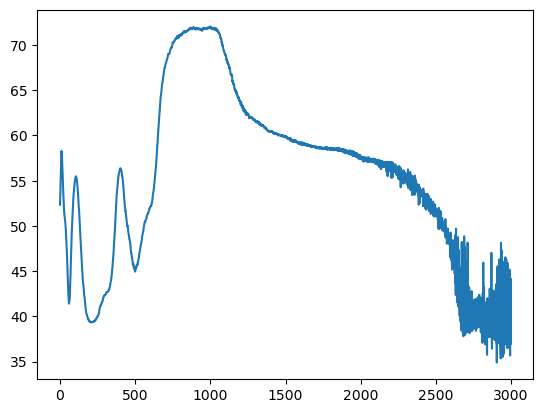

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9d98251a90>

In [311]:
plot(accs)